# Documentation of local entangled states certification code by convex optimization

**Disclaimer:** Everything done in this code is based on a two-qubit bipartite system.

## Topics:
- States
- Measurements
- Deterministic strategies
- SDP
- Results

### Importing the necessary libraries

In [1]:
#Construction:
import picos as pic
import numpy as np
import math
from scipy.spatial import ConvexHull
import time
#Plotting:
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt

### Creating States
Here we will be interested in building the states that we want to certify locality. The **states()** function takes no input and returns the target state and the separable state from the output.


In [2]:
#Creating the states() function
def states():
    #Create the base kets |00>, |01>, |10> and |11>
    ket_00 = np.array([[1],[0],[0],[0]])
    ket_01 = np.array([[0],[1],[0],[0]])
    ket_10 = np.array([[0],[0],[1],[0]])
    ket_11 = np.array([[0],[0],[0],[1]])
    #Create |psi> = (|01>-|10>)/sqrt(2) and rho = |psi><psi|
    psi = (ket_01-ket_10)/math.sqrt(2)
    rho = psi@np.transpose(psi)
    #Create rho_sep = I/4 and rho_00 = |00><00|
    rho_sep = (np.eye(4))/4
    rho_00  = ket_00@np.transpose(ket_00)
    #Return the states created
    return rho, rho_sep , rho_00

In [3]:
#Calling the states() function
rho, rho_sep, rho_00 = states()
#Printing the states created
print('rho:',rho)
print('rho_sep:',rho_sep)
print('rho_00:',rho_00)

rho: [[ 0.   0.   0.   0. ]
 [ 0.   0.5 -0.5  0. ]
 [ 0.  -0.5  0.5  0. ]
 [ 0.   0.   0.   0. ]]
rho_sep: [[0.25 0.   0.   0.  ]
 [0.   0.25 0.   0.  ]
 [0.   0.   0.25 0.  ]
 [0.   0.   0.   0.25]]
rho_00: [[1 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


### Creation of measurements
Here we will be interested in building the measurements. The **measurements(n)** function receives an input referring to the cycle we are interested in, if $n = 1$ we will be building a polytope of 6 vertices, that is, we will be creating 3 dichotomous measurements. In the case $n = 2$ we will keep the vertices from the previous cycle and add 12 vertices, so we will have 9 dichotomous measurements. In the case $n = 3$ we will keep the vertices of the previous cycles and we will have built 13 dichotomous measurements. In the case $n = 4$ we will keep the vertices of the previous cycles and we will have built 21 dichotomous measurements. The function will return 2 outputs, the first will be an array of $2\times2$ matrices that define the projective measurements and the second will be the inscribed radius of the constructed polytope.


In [4]:
#Creating the measurements(n) function
def measurements(n,PLOT=False):
    #INPUT: n is the cicle we are in, may have the values: [1,2,3,4]; PLOT:False/True to plot or not the polyhedron

    #Create the vertices of the polytope
    vert_p = np.array([[1,0,0],[-1,0,0],[0,1,0],[0,-1,0],[0,0,1],[0,0,-1]])

    vert_s = np.array([[0,1/(np.sqrt(2)),1/(np.sqrt(2))],[0,-1/(np.sqrt(2)),-1/(np.sqrt(2))],
    [0,-1/(np.sqrt(2)),1/(np.sqrt(2))],[0,1/(np.sqrt(2)),-1/(np.sqrt(2))],
    [1/(np.sqrt(2)),0,1/(np.sqrt(2))],[-1/(np.sqrt(2)),0,-1/(np.sqrt(2))],
    [-1/(np.sqrt(2)),0,1/(np.sqrt(2))],[1/(np.sqrt(2)),0,-1/(np.sqrt(2))],
    [1/(np.sqrt(2)),1/(np.sqrt(2)),0],[-1/(np.sqrt(2)),-1/(np.sqrt(2)),0],
    [-1/(np.sqrt(2)),1/(np.sqrt(2)),0],[1/(np.sqrt(2)),-1/(np.sqrt(2)),0]
    ])

    vert_s = np.concatenate((vert_p,vert_s))

    vert_t = np.array([[1/2,1/2,1/(np.sqrt(2))],[-1/2,-1/2,-1/(np.sqrt(2))],
    [-1/2,1/2,1/(np.sqrt(2))],[1/2,-1/2,-1/(np.sqrt(2))],
    [1/2,1/2,-1/(np.sqrt(2))],[-1/2,-1/2,1/(np.sqrt(2))],
    [1/2,-1/2,1/(np.sqrt(2))],[-1/2,1/2,-1/(np.sqrt(2))]
    ])

    vert_t = np.concatenate((vert_s,vert_t))

    vert_q = np.array([[1/2,(np.sqrt(3))/2,0],[-1/2,-(np.sqrt(3))/2,0],
    [(np.sqrt(3))/2,1/2,0],[-(np.sqrt(3))/2,-1/2,0],
    [0,(np.sqrt(3))/2,1/2],[0,-(np.sqrt(3))/2,-1/2],
    [(np.sqrt(3))/2,0,1/2],[-(np.sqrt(3))/2,0,-1/2],
    [-1/2,(np.sqrt(3))/2,0],[1/2,-(np.sqrt(3))/2,0],
    [-(np.sqrt(3))/2,1/2,0],[(np.sqrt(3))/2,-1/2,0],
    [0,-(np.sqrt(3))/2,1/2],[0,(np.sqrt(3))/2,-1/2],
    [(np.sqrt(3))/2,0,-1/2],[-(np.sqrt(3))/2,0,1/2]
    ])

    vert_q = np.concatenate((vert_t,vert_q))

    #Choose which set of vertices we want to use depending on the cycle we are in
    if n == 1:
        vert = vert_p
    elif n == 2:
        vert = vert_s
    elif n == 3:
        vert = vert_t
    elif n == 4:
        vert = vert_q

    #Create the measurements of each vertex
    m_k = vert.shape[0]
    medicoes = np.zeros([m_k,2,2], dtype=complex)

    for i in range(m_k):
        med_00 = (1+vert[i][2])/2
        med_01 = (vert[i][0]-vert[i][1]*1j)/2
        med_10 = (vert[i][0]+vert[i][1]*1j)/2
        med_11 = (1-vert[i][2])/2
    
        medicoes[i] = [[med_00,med_01],[med_10,med_11]]

    #Verify that the sum of each dichotomous measurement is the identity
    for i in range(int(m_k/2)):
        print("Sum")
        print(medicoes[2*i]+medicoes[2*i+1])
    
    #Construct the polyhedron
    hull = ConvexHull(vert)

    print(hull.equations)
    #Find the Insphere radius
    r = np.min(np.abs(hull.equations[:, -1]))

    #Plot
    if PLOT == True:
        polys = Poly3DCollection([hull.points[simplex] for simplex in hull.simplices])

        polys.set_edgecolor('deeppink')
        polys.set_linewidth(.8)
        polys.set_facecolor('hotpink')
        polys.set_alpha(.25)
        
        #Build the insphere
        u, v = np.mgrid[0:2*np.pi:50j, 0:np.pi:50j]
        x = r*np.cos(u)*np.sin(v)
        y = r*np.sin(u)*np.sin(v)
        z = r*np.cos(v)
        
        #Build the Bloch sphere
        x_uni = np.cos(u)*np.sin(v)
        y_uni = np.sin(u)*np.sin(v)
        z_uni = np.cos(v)
        
        ax = Axes3D(plt.figure())
        
        #Plot insphere
        ax.plot_surface(x,y,z,color='lime',alpha=.35)
        #Plot Bloch sphere
        ax.plot_surface(x_uni,y_uni,z_uni,color='lightgray',alpha=.15)
        #Plot polyhedron
        ax.set_xlim3d(-1,1)
        ax.set_ylim3d(-1,1)
        ax.set_zlim3d(-1,1)
        ax.set_box_aspect([1,1,1])
        #plt.axis('off')

        ax.add_collection3d(polys)
        #plt.show()
        plt.savefig('poliedro_'+str(m_k)+'.png')
    
    #Return the measurements and the insphere radius
    return medicoes,r

Sum
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Sum
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Sum
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
[[-0.57735027 -0.57735027 -0.57735027 -0.57735027]
 [ 0.57735027 -0.57735027 -0.57735027 -0.57735027]
 [-0.57735027 -0.57735027  0.57735027 -0.57735027]
 [ 0.57735027 -0.57735027  0.57735027 -0.57735027]
 [ 0.57735027  0.57735027 -0.57735027 -0.57735027]
 [-0.57735027  0.57735027 -0.57735027 -0.57735027]
 [ 0.57735027  0.57735027  0.57735027 -0.57735027]
 [-0.57735027  0.57735027  0.57735027 -0.57735027]]
Sum
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Sum
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Sum
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
[[-0.57735027 -0.57735027 -0.57735027 -0.57735027]
 [ 0.57735027 -0.57735027 -0.57735027 -0.57735027]
 [-0.57735027 -0.57735027  0.57735027 -0.57735027]
 [ 0.57735027 -0.57735027  0.57735027 -0.57735027]
 [ 0.57735027  0.57735027 -0.57735027 -0.57735027]
 [-0.57735027  0.57735027 -0.57735027 -0.57735027]
 [ 0.57735027  0.57735027  0.57735027 -0.57735027]


/tmp/ipykernel_8663/2305413259.py:92: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(plt.figure())


Measurements: [[[ 0.5+0.j   0.5+0.j ]
  [ 0.5+0.j   0.5+0.j ]]

 [[ 0.5+0.j  -0.5+0.j ]
  [-0.5+0.j   0.5+0.j ]]

 [[ 0.5+0.j   0. -0.5j]
  [ 0. +0.5j  0.5+0.j ]]

 [[ 0.5+0.j   0. +0.5j]
  [ 0. -0.5j  0.5+0.j ]]

 [[ 1. +0.j   0. +0.j ]
  [ 0. +0.j   0. +0.j ]]

 [[ 0. +0.j   0. +0.j ]
  [ 0. +0.j   1. +0.j ]]]
r: 0.5773502691896258


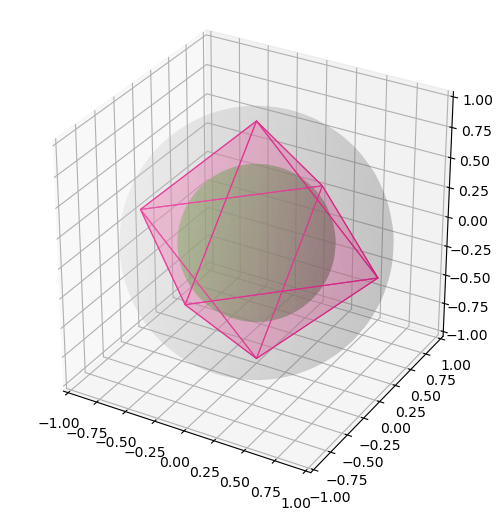

In [5]:
#Calling the measurements(n,PLOT=False) function
medicoes, r = measurements(1)
#Calling the measurements(n,PLOT=True) function
medicoes, r = measurements(1,PLOT=True)
#Printing the measurements created and the insphere radius
print("Measurements:",medicoes)
print("r:",r)

### Creation of Deterministic Strategies
Here we will be interested in building the deterministic strategies. Since they are deterministic, given a result $a$ of a measurement $\hat{v}_x$, the associated probability will be either 0 or 1. It is possible to determine all the $k^m$ ($k$ being the number of results per measurement and $m$ the number of measurements) possible deterministic strategies in the format
$D_\lambda = (D_\lambda(a_1|\hat{v}_1),D_\lambda(a_2|\hat{v}_1),\cdots\!,D_\lambda(a_k|\hat{v }_1),\cdots\!,D_\lambda(b_k|\hat{v}_m)),$
with $\sum_{i=1}^k D_\lambda(a_i,\hat{v}_j) = 1$ for all $1\leq j\leq m$.

In [6]:
#Creating the strategies_LHS(m,k) function
def strategies_LHS(m,k):
    #INPUT: m = number of measurements; k = number of results
    #k**m = number of strategies = n_lambdas

    n_lambdas = k**m
    
    #Creating the strategies
    all_est = [np.base_repr(el+n_lambdas,base=k)[-m:] for el in range(n_lambdas)]
    
    all_est = np.array([[int(digit) for digit in el] for el in all_est])

    detp = np.zeros((n_lambdas,k*m))

    for i in range(n_lambdas):
        for j in range(m):
            aux = np.zeros(k)
            aux[all_est[i][j]] = 1
            detp[i][j*k:j*k+k] = np.array(aux)    
            
    #Return the deterministic strategies
    return detp

In [7]:
#Calling the strategies_LHS(m,k) function
detp = strategies_LHS(3,2)
#Printing the deterministic strategies created
print("Deterministic strategies:",detp)

Deterministic strategies: [[1. 0. 1. 0. 1. 0.]
 [1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0.]
 [1. 0. 0. 1. 0. 1.]
 [0. 1. 1. 0. 1. 0.]
 [0. 1. 1. 0. 0. 1.]
 [0. 1. 0. 1. 1. 0.]
 [0. 1. 0. 1. 0. 1.]]


### Creating the SDP

Starting with the following theorem:

**Theorem:**

Let $\mathcal{M}$ be a finite collection of projective measurements on $\mathbb{C}^{d_A}$. A state $\rho_{AB}$ acting on $\mathbb{C}^{d_A}\otimes\mathbb{C}^{d_B}$ admits an LHS model for all projective measurements if there is a unit trace operator $ O_{AB}$ acting on the same Hilbert space, so that $O_{AB}$ admits an LHS model for measurements in $\mathcal{M}$, and
$$\rho_{AB} = rO_{AB}+(1-r)\frac{1}{d_A}\mathbb{I}_A\otimes O_B,$$
where $r$ is the radius of the inner sphere, the largest centered sphere contained in the polytope generated by $\mathcal{M}$.

Here we will be interested in states of the form
$$\rho_{AB} = \rho_q = q\rho+(1-q)\rho_{\text{sep}},$$
with $0\leq q\leq 1$, and where the state $\rho$ may be called the *target state* and $\rho_{\text{sep}}$ is a separable state (hence unsteerable).

Thus, according to the Theorem, the following SDP tests an LHS model for projective measurements in the $\rho_{AB}$ state:
\begin{align*}
\text{maximise}&\quad q\\
s.t.&\quad \text{tr}_A[(\Pi_{a|\hat{v}_x}\otimes\mathbb{I}_B)O_{AB}] = \sum_\lambda D_\lambda(a|x)\rho_\lambda,\quad\forall a,x\\
&\quad\rho_\lambda\geq0,\quad\forall\lambda\\
&\quad rO_{AB}+(1-r)\xi\otimes O_B = \rho_q.
\end{align*}
where $\xi = \text{tr}_B(\rho_{\text{sep}})$.

In [8]:
#Creating the SDP_LHS(m,k,rho,rho_sep,eta,detp,medicoes) function
def SDP_LHS(m,k,rho,rho_sep,eta,detp,medicoes):

    #Creating the problem
    P = pic.Problem()

    #Creating the optimization variables
    q = pic.RealVariable('q')

    chi = pic.HermitianVariable('chi',(4,4))

    sigma = [pic.HermitianVariable('Sigma_lambda[{}]'.format(i),(2,2)) for i in range(k**m)]

    rho_q = rho*q+(1-q)*rho_sep

    rho_eta = eta*chi+(1-eta)*(pic.partial_trace(rho_sep,subsystems=1,dimensions=(2,2)))@(pic.partial_trace(chi,subsystems=0,dimensions=(2,2)))

    est_det = [pic.sum([sigma[j]*detp[j,i] for j in range(k**m)]) for i in range(k*m)]

    est = [(np.kron(medicoes[i],np.eye(2)))*chi for i in range(k*m)]

    #Creating the constraints
    P.add_constraint(q<=1)

    P.add_constraint(q>=0)

    P.add_list_of_constraints([sigma[i]>>0 for i in range(k**m)]) 

    P.add_constraint(rho_q == rho_eta)

    P.add_list_of_constraints([pic.partial_trace(est[i],subsystems=0,dimensions=(2,2))==est_det[i] for i in range(k*m)])

    #Setting the objective
    P.set_objective('max',q)

    #Finding the solution
    solution = P.solve()

    #Return the problem created, the solution found, the value of q
    return P, solution, q


### Finding the results

In [9]:
#Calling the functions 
#Creating the states
rho,rho_sep, rho_00 = states()

for i in range(1):
    print('Starting cycle ',i+1,'.')

    #Creating the measurements
    medicoes,r = measurements(i+1)
    m_k = medicoes.shape
    print('Number of vertices:')
    print(m_k[0])
    print('Insphere radius:')
    print(r)

    k = 2
    m = int(m_k[0]/k)

    #Creating the deterministic strategies
    detp = strategies_LHS(m,k)

    #Calling the SDP_LHS(m,k,rho,rho_00,r,detp,medicoes) function
    P,solution,q = SDP_LHS(m,k,rho,rho_00,r,detp,medicoes)

    #Printing the results
    print("Problem")
    print(P)
    print("Solution")
    print(solution)
    print('Value of q: ',q)
    print('Cycle ',i+1,' finished.')

Starting cycle  1 .
Sum
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Sum
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
Sum
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]
[[-0.57735027 -0.57735027 -0.57735027 -0.57735027]
 [ 0.57735027 -0.57735027 -0.57735027 -0.57735027]
 [-0.57735027 -0.57735027  0.57735027 -0.57735027]
 [ 0.57735027 -0.57735027  0.57735027 -0.57735027]
 [ 0.57735027  0.57735027 -0.57735027 -0.57735027]
 [-0.57735027  0.57735027 -0.57735027 -0.57735027]
 [ 0.57735027  0.57735027  0.57735027 -0.57735027]
 [-0.57735027  0.57735027  0.57735027 -0.57735027]]
Number of vertices:
6
Insphere radius:
0.5773502691896258


ValueError: domain error